In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import networkx as nx

from skfeature.function.similarity_based import fisher_score, lap_score
from skfeature.utility import construct_W
from scipy.sparse import csc_matrix

from sklearn.manifold import MDS
from sklearn.preprocessing import StandardScaler,MinMaxScaler

In [2]:
def myW(data,k):
    n_samples,n_features = np.shape(data)
    D = np.arccos(abs(np.corrcoef(data.T)))
    dump = np.sort(D,axis=1)
    idx = np.argsort(D,axis=1)
    idx_new = idx[:,:k+1]
    dump_new = dump[:,:k+1]
    
    G = np.zeros((n_features*(k+1),3))
    G[:, 0] = np.tile(np.arange(n_features), (k+1, 1)).reshape(-1)
    G[:, 1] = np.ravel(idx_new, order='F')
    G[:, 2] = np.ravel(dump_new, order='F')
    
    W = csc_matrix((G[:, 2], (G[:, 0], G[:, 1])), shape=(n_features, n_features))
    bigger = np.transpose(W) > W
    W = W - W.multiply(bigger) + np.transpose(W).multiply(bigger)
    return W

In [60]:
def normalizedMorseIndex(W,score):
    result = pd.Series(index=score.index)
    for i in np.arange(len(result)):
        degree = len(np.setdiff1d(W.getrow(i).nonzero()[1],i))
        result[i] = sum((score[W.getrow(i).nonzero()[1]]<score[i])*1) / degree
    return result

In [215]:
nmi[nmi==1].index

Int64Index([  2,  19,  25, 102, 130, 172, 186, 213, 352, 389, 394, 418, 432,
            435, 478, 488, 536, 543, 547],
           dtype='int64')

In [216]:
def localMaxSelection(W,score,r=1,num_result=np.inf):
    nmi = normalizedMorseIndex(W,score)
    selected_features = []
    c = 0
    while(not nmi.empty and c<num_result):
        new_feature = score[nmi[nmi==1].index].idxmax() if 1 in nmi.to_numpy() else nmi.idxmax()
        selected_features.append(new_feature)
        feature_idx = score.index.tolist().index(new_feature)
        nbhd = np.array([new_feature])
        for i in np.arange(r):
            for f in nbhd:
                nbhd = np.append(nbhd,np.setdiff1d(W.getrow(f).nonzero()[1],f))
            nbhd = np.unique(nbhd)
        nmi = nmi.drop(np.intersect1d(nbhd,nmi.index.to_numpy()))
        c+=1
    return selected_features

In [3]:
rawdata = pd.read_csv('data/isolet1+2+3+4.data.csv',header=None)
rawdata.head()

,0,1,2,3,4,5,6,7,8,9,...,608,609,610,611,612,613,614,615,616,617
0,-0.4394,-0.0930,0.1718,0.4620,0.6226,0.4704,0.3578,0.0478,-0.1184,-0.2310,...,0.4102,0.2052,0.3846,0.3590,0.5898,0.3334,0.6410,0.5898,-0.4872,1.0
1,-0.4348,-0.1198,0.2474,0.4036,0.5026,0.6328,0.4948,0.0338,-0.0520,-0.1302,...,0.0000,0.2954,0.2046,0.4772,0.0454,0.2046,0.4318,0.4546,-0.0910,1.0
2,-0.2330,0.2124,0.5014,0.5222,-0.3422,-0.5840,-0.7168,-0.6342,-0.8614,-0.8318,...,-0.1112,-0.0476,-0.1746,0.0318,-0.0476,0.1112,0.2540,0.1588,-0.4762,2.0
3,-0.3808,-0.0096,0.2602,0.2554,-0.4290,-0.6746,-0.6868,-0.6650,-0.8410,-0.9614,...,-0.0504,-0.0360,-0.1224,0.1366,0.2950,0.0792,-0.0072,0.0936,-0.1510,2.0
4,-0.3412,0.0946,0.6082,0.6216,-0.1622,-0.3784,-0.4324,-0.4358,-0.4966,-0.5406,...,0.1562,0.3124,0.2500,-0.0938,0.1562,0.3124,0.3124,0.2188,-0.2500,3.0


In [4]:
data = rawdata.iloc[:,:-1]
data.head()

,0,1,2,3,4,5,6,7,8,9,...,607,608,609,610,611,612,613,614,615,616
0,-0.4394,-0.0930,0.1718,0.4620,0.6226,0.4704,0.3578,0.0478,-0.1184,-0.2310,...,0.3334,0.4102,0.2052,0.3846,0.3590,0.5898,0.3334,0.6410,0.5898,-0.4872
1,-0.4348,-0.1198,0.2474,0.4036,0.5026,0.6328,0.4948,0.0338,-0.0520,-0.1302,...,0.2272,0.0000,0.2954,0.2046,0.4772,0.0454,0.2046,0.4318,0.4546,-0.0910
2,-0.2330,0.2124,0.5014,0.5222,-0.3422,-0.5840,-0.7168,-0.6342,-0.8614,-0.8318,...,0.0952,-0.1112,-0.0476,-0.1746,0.0318,-0.0476,0.1112,0.2540,0.1588,-0.4762
3,-0.3808,-0.0096,0.2602,0.2554,-0.4290,-0.6746,-0.6868,-0.6650,-0.8410,-0.9614,...,0.0648,-0.0504,-0.0360,-0.1224,0.1366,0.2950,0.0792,-0.0072,0.0936,-0.1510
4,-0.3412,0.0946,0.6082,0.6216,-0.1622,-0.3784,-0.4324,-0.4358,-0.4966,-0.5406,...,0.2812,0.1562,0.3124,0.2500,-0.0938,0.1562,0.3124,0.3124,0.2188,-0.2500


In [5]:
label = rawdata.iloc[:,-1]
label.head()

0    1.0
1    1.0
2    2.0
3    2.0
4    3.0
Name: 617, dtype: float64

In [6]:
data_scaled = StandardScaler().fit_transform(data)
data_normalized = MinMaxScaler().fit_transform(data)

In [7]:
score = pd.Series(fisher_score.fisher_score(data.to_numpy(),label),index=data.columns)

/Users/jaeminpark/anaconda3/lib/python3.7/site-packages/scipy/sparse/lil.py:518: FutureWarning: future versions will not create a writeable array from broadcast_array. Set the writable flag explicitly to avoid this warning.
  if not x.flags.writeable:


In [8]:
W = myW(data_scaled,6)

In [9]:
G = nx.Graph(W.toarray())
pos = nx.kamada_kawai_layout(G)

/Users/jaeminpark/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


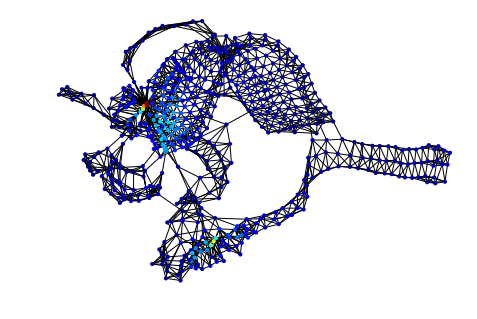

In [10]:
nx.draw(G,pos=pos,node_size=10,node_color=score,cmap=plt.cm.jet)

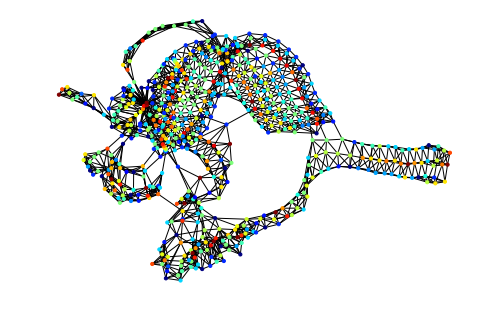

In [176]:
nmi = normalizedMorseIndex(W,score)
nx.draw(G,pos=pos,node_size=10,node_color=nmi,cmap=plt.cm.jet)

In [217]:
selected_features = localMaxSelection(W,score,3,num_result=30)

/Users/jaeminpark/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


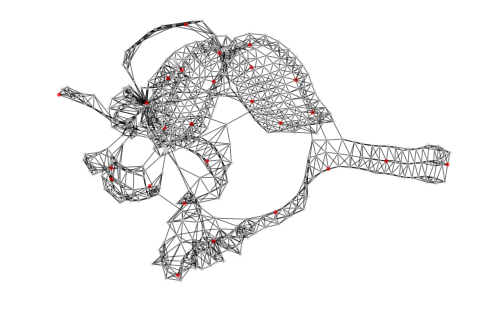

In [218]:
selected_label = np.where(np.isin(score.index.to_numpy(),selected_features),'r','lightgray')

nx.draw(G,pos=pos,node_size=10,node_color=selected_label,alpha=0.5)

In [198]:
dist = np.arccos(abs(np.corrcoef(data_scaled.T)))
mds_feature = MDS(dissimilarity='precomputed').fit_transform(dist)

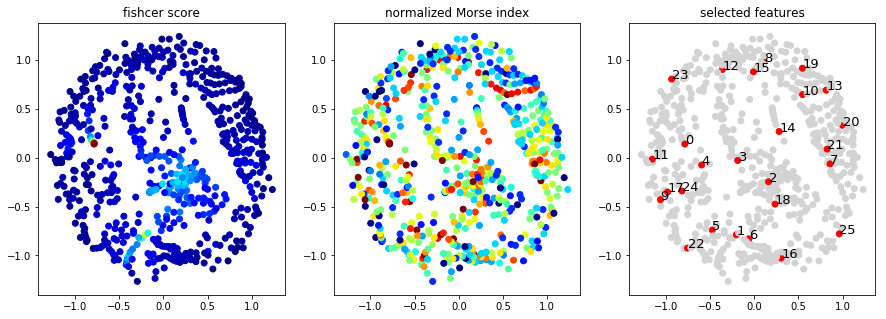

In [219]:
fig,ax = plt.subplots(1,3,figsize=(15,5))

ax[0].scatter(mds_feature[:,0],mds_feature[:,1],c=score,cmap=plt.cm.jet)
ax[0].set_title('fishcer score')

ax[1].scatter(mds_feature[:,0],mds_feature[:,1],c=nmi,cmap=plt.cm.jet)
ax[1].set_title('normalized Morse index')

ax[2].scatter(mds_feature[:,0],mds_feature[:,1],c=selected_label)
ax[2].set_title('selected features')
for i,f in enumerate(selected_features):
    r = np.where(data.columns==f)[0]
    ax[2].text(mds_feature[r,0],mds_feature[r,1],i,fontsize=13)